# Basic Model Testing

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

In [2]:
mod1 = torch.load(sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')

In [3]:
for name in mod1['state_dict']:
    print(name)

module.conv1.weight
module.bn1.weight
module.bn1.bias
module.bn1.running_mean
module.bn1.running_var
module.bn1.num_batches_tracked
module.layer1.0.conv1.weight
module.layer1.0.bn1.weight
module.layer1.0.bn1.bias
module.layer1.0.bn1.running_mean
module.layer1.0.bn1.running_var
module.layer1.0.bn1.num_batches_tracked
module.layer1.0.conv2.weight
module.layer1.0.bn2.weight
module.layer1.0.bn2.bias
module.layer1.0.bn2.running_mean
module.layer1.0.bn2.running_var
module.layer1.0.bn2.num_batches_tracked
module.layer1.1.conv1.weight
module.layer1.1.bn1.weight
module.layer1.1.bn1.bias
module.layer1.1.bn1.running_mean
module.layer1.1.bn1.running_var
module.layer1.1.bn1.num_batches_tracked
module.layer1.1.conv2.weight
module.layer1.1.bn2.weight
module.layer1.1.bn2.bias
module.layer1.1.bn2.running_mean
module.layer1.1.bn2.running_var
module.layer1.1.bn2.num_batches_tracked
module.layer2.0.conv1.weight
module.layer2.0.bn1.weight
module.layer2.0.bn1.bias
module.layer2.0.bn1.running_mean
module.lay

# Loading the Dataset

In [4]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [5]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [6]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

In [7]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

Create opt for passing to the constructor. \
Also pass a string with the training value

## Loading Full Dataset

In [8]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=15.14s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [9]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287


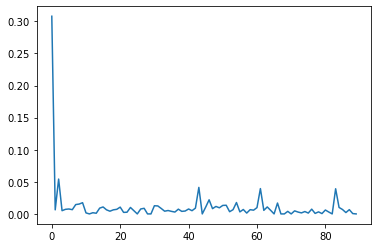

In [10]:
N=512
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [11]:
opt.num_iters = dataset.num_samples/opt.batch_size
print(dataset.images)

[146757, 65057, 293851, 358438, 65213, 455480, 392887, 251752, 400709, 366501, 510820, 129782, 579568, 370831, 320045, 327529, 517095, 334746, 1902, 436391, 384213, 579760, 565849, 312789, 148792, 431146, 160308, 458205, 69856, 243446, 151277, 242868, 344702, 546031, 372219, 426714, 293159, 119036, 250958, 78016, 384412, 398007, 493355, 508015, 380734, 104309, 127129, 178378, 524723, 470414, 267217, 386542, 123514, 423362, 98612, 119210, 167082, 11788, 523267, 217515, 460809, 336621, 215524, 284144, 288246, 81838, 554934, 404626, 259758, 194108, 483620, 327221, 293070, 61603, 442590, 70256, 500537, 188040, 550529, 409706, 182903, 204805, 461128, 371978, 139634, 493717, 248948, 253656, 211823, 61459, 471064, 388255, 537470, 283849, 222330, 542284, 487236, 218853, 558584, 262101, 138975, 397645, 359760, 312997, 521569, 171585, 121249, 219313, 127028, 196299, 95078, 442901, 342160, 558303, 480807, 552330, 134715, 487349, 237222, 221252, 385744, 433044, 281181, 290578, 438816, 79544, 27896

## Dataloader

In [11]:
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [12]:
val_loader = torch.utils.data.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

# Model

In [13]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [14]:
# regression on center point.
model = create_model(opt.arch, opt.heads, opt.head_conv)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg-cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.3MB/s]


=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


In [15]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Trainer

In [ ]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

# Running main training loop

In [ ]:
## Test for Using their train function from Ctdetrainer
# print('Starting training...')
# best = 1e10
# for epoch in range(start_epoch + 1, opt.num_epochs + 1):
#     log_dict_train, _ = trainer.train(epoch, train_loader)
    

In [16]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [17]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    pass
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [18]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    #image=np.int(((image-np.min(image))/(np.max(image)-np.min(image)))*255)
    #print(image.shape)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [19]:
model1 =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')
net = Centernet_model(opt,model1)
net = net.to(opt.device)
print(train_loader)
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

loaded /datasets/home/home-01/30/230/psarangi/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140
Skip loading parameter deconv_layers.0.weight, required shapetorch.Size([512, 256, 4, 4]), loaded shapetorch.Size([256, 512, 3, 3]). If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
Drop parameter deconv_layers.0.bias.If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
Drop parameter deconv_layers.0.conv_offset_mask.weight.If you see this, your model does not fully load the pre-trained weight. Please make sure you have correctly specified --arch xxx or set the correct --num_classes for your own dataset.
Drop parameter deconv_layers.0.conv_offset_mask.bias.If you see this, your model does not fully

## Data Augmentation

In [ ]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    print(idx)
    x1=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x1[0,:,:,:])
    print(x1[0,:,:,:].shape,I.shape)

In [ ]:
torch.equal(x,x1)
print()

In [ ]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    x=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x[0,:,:,:])
    print(x[0,:,:,:].shape,I.shape)

## Manual Batch Loss computation

In [ ]:
for idx,batch in enumerate(train_loader):
    #print(idx)
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=opt.device, non_blocking=True) 
    y=net.model(batch['input'])
    #y=net.model(batch['input'])
    #batch = batch.to(net.device)
    #y,_,_=net.model_with_loss(batch)
    #print(idx)
    loss1,_ = net.loss(y,batch)

In [ ]:
print(loss1.mean())

In [21]:
for name,param in net.model.named_parameters():
    print(name,param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

## Experiment with custom function run2

In [20]:
adam = torch.optim.Adam(net.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp2 = nt.Experiment(net,dataset,valset,adam,stats_manager,
output_dir="olalalaeo4", batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp2.run2(num_epochs=5)

Start/Continue training from epoch 0


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1 (Time: 32.50s)
Epoch 2 (Time: 29.38s)
Epoch 3 (Time: 29.55s)
Epoch 4 (Time: 28.25s)


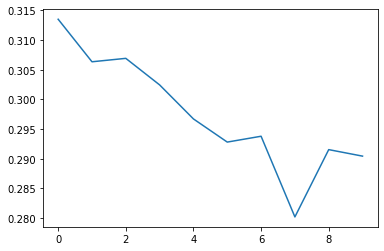

In [27]:
plt.plot(exp2.history)
plt.show()